In [1]:
import os
import argparse
import copy
import json
import numpy
import pandas
import umap
import matplotlib
import seaborn
from apricot import FeatureBasedSelection
from matplotlib import pyplot
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler

## Load data

In [2]:
# f = "../data/train.json"
f = "../data/hotel_room_classroom_living_room_kitchen_office.json"
lsa_repsize = 64
max_size = 2000
subset_frac = 0.1

In [3]:
with open(f) as json_file:
    d = json.load(json_file)

## Extract corpus, vocabulary, labels

In [4]:
corpus = []
Y = []
vocabulary = set()
for r in d["data"]:
    corpus.append(r["asr_text"])
    for w in r["asr_text"].split(" "):
        vocabulary.add(w)
    Y.append(r["uttid"])

Y = numpy.array(Y)

# tf-idf, LSA

In [5]:
p = Pipeline([("count", CountVectorizer(vocabulary=vocabulary)), ("tfidf", TfidfTransformer())]).fit(corpus)
X = p.transform(corpus)
svd = TruncatedSVD(n_components=lsa_repsize)
X = svd.fit_transform(X)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

## Subset selection

In [6]:
total_samples = X.shape[0]
n_samples = min(int(total_samples * subset_frac), max_size)
fsb = FeatureBasedSelection(n_samples, verbose=True)
core_X, core_indices = fsb.fit_transform(X, numpy.arange(len(Y)))
core_Y = set(Y[core_indices])

100%|██████████| 1.95k/1.95k [05:58<00:00, 5.44it/s] 


In [7]:
new_partition = copy.deepcopy(d)
new_partition["data"] = []

for i, r in enumerate(d["data"]):
    if r["uttid"] in core_Y:
        new_partition["data"].append(r)

In [8]:
fn, ext = os.path.splitext(f)
with open(fn + ("_core%d" % n_samples) + ext, "w") as json_file:
    json.dump(new_partition, json_file)

## Plot subset

In [9]:
dr = umap.UMAP(n_components=2)
X_2d = dr.fit_transform(X)

In [10]:
df = pandas.DataFrame(X_2d, columns=["x", "y"])
df["Selected"] = False
df["Selected"].values[core_indices] = True

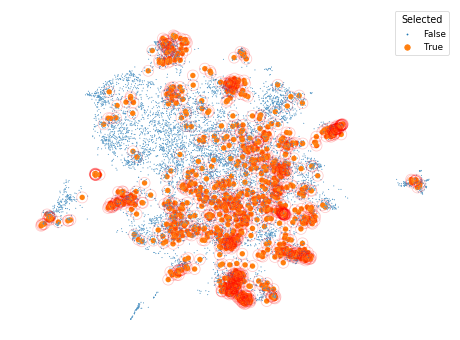

In [11]:
n_sample = 10000
j = df.sample(n=n_sample)
seaborn.set_context("paper")
pyplot.figure(figsize=(8, 6))
g = seaborn.scatterplot(x="x", y="y", size="Selected", hue="Selected", sizes={False: 1, True: 30}, data=j)
pyplot.scatter(j[j["Selected"] == True]["x"], j[j["Selected"] == True]["y"], s=120, color="none", edgecolor="r", alpha=0.2)
g.set_xlim(j[j["Selected"] == True]["x"].max() + 1, j[j["Selected"] == True]["x"].min() - 1)
g.set_ylim(j[j["Selected"] == True]["y"].max() + 1, j[j["Selected"] == True]["y"].min() - 1)
seaborn.despine(left=True, bottom=True)
g.axes.get_xaxis().set_visible(False)
g.axes.get_yaxis().set_visible(False)
pyplot.savefig("selected.png", bbox_inches="tight")